In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx
/kaggle/input/widsdatathon2025/Data Dictionary.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAINING_SOLUTIONS.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
from sklearn.model_selection import KFold

## EDA

### Data Dictionary

In [9]:
dict = pd.read_excel("/kaggle/input/widsdatathon2025/Data Dictionary.xlsx")

In [10]:
dict

,DataType,Instrument,Field,Description,Type,Labels
0,QUANTITATIVE METADATA,NaN,NaN,NaN,NaN,NaN
1,NaN,Identifier,participant_id,Participant ID,str,NaN
2,Quantitative,Edinburgh Handedness Questionnaire,EHQ_EHQ_Total,Laterality Index (Score),float,-100 = 10th left\n−28 ≤ LI < 48 = middle\n100 ...
3,Quantitative,Ishihara Color Vision Test,ColorVision_CV_Score,Color vision test score,int,NaN
4,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_CP,Corporal Punishment Score,int,NaN
5,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_ID,Inconsistent Discipline Score,int,NaN
6,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_INV,Involvement Score,int,NaN
7,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_OPD,Other Discipline Practices Score (Not factored...,int,NaN
8,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PM,Poor Monitoring/Supervision Score,int,NaN
9,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PP,Positive Parenting Score,int,NaN


### Categorical Features

In [11]:
train_cat = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
test_cat = pd.read_excel("/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")

In [12]:
print(train_cat.shape)
print(test_cat.shape)

(1213, 10)
(304, 10)


In [13]:
train_cat.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


In [14]:
cat_columns = train_cat.columns
cat_columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

In [15]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1170 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1159 non-null   float64
 5   MRI_Track_Scan_Location           1210 non-null   float64
 6   Barratt_Barratt_P1_Edu            1198 non-null   float64
 7   Barratt_Barratt_P1_Occ            1182 non-null   float64
 8   Barratt_Barratt_P2_Edu            1015 non-null   float64
 9   Barratt_Barratt_P2_Occ            991 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 94.9+ KB


In [16]:
train_cat.isna().sum()

participant_id                        0
Basic_Demos_Enroll_Year               0
Basic_Demos_Study_Site                0
PreInt_Demos_Fam_Child_Ethnicity     43
PreInt_Demos_Fam_Child_Race          54
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               15
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P2_Edu              198
Barratt_Barratt_P2_Occ              222
dtype: int64

In [17]:
test_cat.isna().sum()

participant_id                       0
Basic_Demos_Enroll_Year              0
Basic_Demos_Study_Site               0
PreInt_Demos_Fam_Child_Ethnicity     3
PreInt_Demos_Fam_Child_Race          6
MRI_Track_Scan_Location              0
Barratt_Barratt_P1_Edu               1
Barratt_Barratt_P1_Occ               1
Barratt_Barratt_P2_Edu              36
Barratt_Barratt_P2_Occ              42
dtype: int64

### Quantitative Features

In [18]:
train_quant = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
test_quant = pd.read_excel("/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

In [19]:
print(train_quant.shape)
print(test_quant.shape)

(1213, 19)
(304, 19)


In [20]:
train_quant.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [21]:
train_quant.isna().sum()

participant_id                  0
EHQ_EHQ_Total                  13
ColorVision_CV_Score           23
APQ_P_APQ_P_CP                 12
APQ_P_APQ_P_ID                 12
APQ_P_APQ_P_INV                12
APQ_P_APQ_P_OPD                12
APQ_P_APQ_P_PM                 12
APQ_P_APQ_P_PP                 12
SDQ_SDQ_Conduct_Problems        9
SDQ_SDQ_Difficulties_Total      9
SDQ_SDQ_Emotional_Problems      9
SDQ_SDQ_Externalizing           9
SDQ_SDQ_Generating_Impact       9
SDQ_SDQ_Hyperactivity           9
SDQ_SDQ_Internalizing           9
SDQ_SDQ_Peer_Problems           9
SDQ_SDQ_Prosocial               9
MRI_Track_Age_at_Scan         360
dtype: int64

In [22]:
test_quant.isna().sum()

participant_id                 0
EHQ_EHQ_Total                  1
ColorVision_CV_Score           9
APQ_P_APQ_P_CP                15
APQ_P_APQ_P_ID                15
APQ_P_APQ_P_INV               15
APQ_P_APQ_P_OPD               15
APQ_P_APQ_P_PM                15
APQ_P_APQ_P_PP                15
SDQ_SDQ_Conduct_Problems      30
SDQ_SDQ_Difficulties_Total    30
SDQ_SDQ_Emotional_Problems    30
SDQ_SDQ_Externalizing         30
SDQ_SDQ_Generating_Impact     30
SDQ_SDQ_Hyperactivity         30
SDQ_SDQ_Internalizing         30
SDQ_SDQ_Peer_Problems         30
SDQ_SDQ_Prosocial             30
MRI_Track_Age_at_Scan          0
dtype: int64

In [23]:
train_quant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   participant_id              1213 non-null   object 
 1   EHQ_EHQ_Total               1200 non-null   float64
 2   ColorVision_CV_Score        1190 non-null   float64
 3   APQ_P_APQ_P_CP              1201 non-null   float64
 4   APQ_P_APQ_P_ID              1201 non-null   float64
 5   APQ_P_APQ_P_INV             1201 non-null   float64
 6   APQ_P_APQ_P_OPD             1201 non-null   float64
 7   APQ_P_APQ_P_PM              1201 non-null   float64
 8   APQ_P_APQ_P_PP              1201 non-null   float64
 9   SDQ_SDQ_Conduct_Problems    1204 non-null   float64
 10  SDQ_SDQ_Difficulties_Total  1204 non-null   float64
 11  SDQ_SDQ_Emotional_Problems  1204 non-null   float64
 12  SDQ_SDQ_Externalizing       1204 non-null   float64
 13  SDQ_SDQ_Generating_Impact   1204 

### Targets

0= Other/None, 1=ADHD

0=Male   
1=Female


In [24]:
targets = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

In [25]:
targets.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


Text(0, 0.5, 'Count')

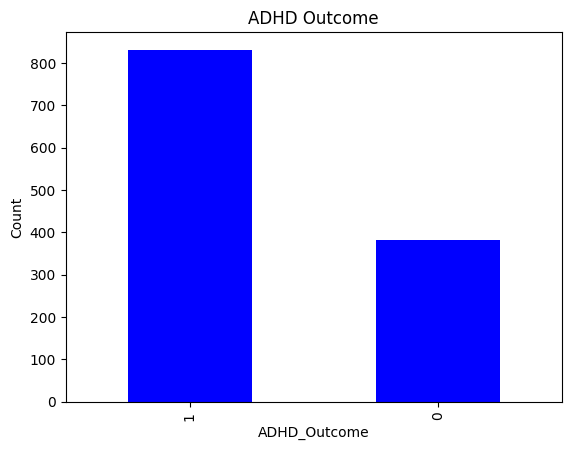

In [26]:
targets['ADHD_Outcome'].value_counts().plot(kind='bar', color='blue')
plt.title('ADHD Outcome')
plt.ylabel("Count")

Text(0, 0.5, 'Count')

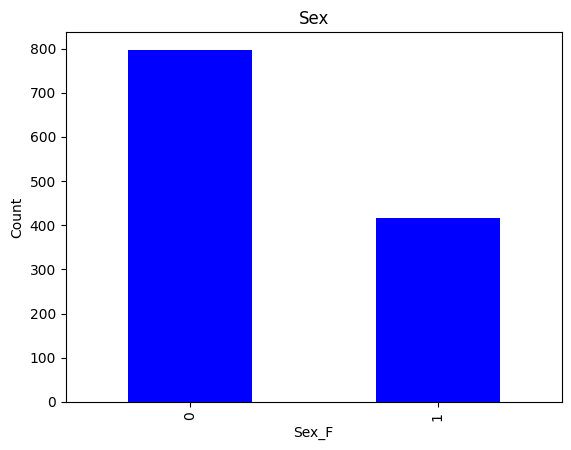

In [27]:
targets['Sex_F'].value_counts().plot(kind='bar', color='blue')
plt.title('Sex')
plt.ylabel("Count")

## Preprocessing

### Categorical variables

#### Impute missing values

In [28]:
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(train_cat) 

train_cat_imputed = pd.DataFrame(imputer.transform(train_cat), columns=cat_columns)
test_cat_imputed = pd.DataFrame(imputer.transform(test_cat), columns=cat_columns)

for name, df in {"train": train_cat_imputed, "test": test_cat_imputed}.items():
    if df.isna().sum().sum() == 0:
        print(f"Missing values imputed for {name} categorical features")
    else:
        print(f"Some missing values still remain in {name} categorical features")

Missing values imputed for train categorical features
Missing values imputed for test categorical features


#### One hot encoding

In [29]:
for col in train_cat_imputed.select_dtypes(include=["int", "float"]).columns:
    train_cat_imputed[col] = train_cat_imputed[col].astype('category')
    test_cat_imputed[col] = test_cat_imputed[col].astype('category')
    

In [30]:
columns_to_encode = train_cat_imputed.columns[1:].tolist()
columns_to_encode

['Basic_Demos_Enroll_Year',
 'Basic_Demos_Study_Site',
 'PreInt_Demos_Fam_Child_Ethnicity',
 'PreInt_Demos_Fam_Child_Race',
 'MRI_Track_Scan_Location',
 'Barratt_Barratt_P1_Edu',
 'Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Barratt_Barratt_P2_Occ']

In [31]:
encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(train_cat_imputed[columns_to_encode])
train_cat_encoded = encoder.transform(train_cat_imputed[columns_to_encode])
test_cat_encoded = encoder.transform(test_cat_imputed[columns_to_encode])

train_cat_encoded = train_cat_encoded.toarray()
test_cat_encoded = test_cat_encoded.toarray()

# Get feature names from the encoder
encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)

# Convert to DataFrame
train_cat_encoded = pd.DataFrame(train_cat_encoded, columns=encoded_feature_names)
test_cat_encoded = pd.DataFrame(test_cat_encoded, columns=encoded_feature_names)

if train_cat_encoded.shape[1] == test_cat_encoded.shape[1]:
    print("train and test categorical features are aligned")
else:
    print("Check required!")

train_cat_encoded.head()

train and test categorical features are aligned


,Basic_Demos_Enroll_Year_2015,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,...,Barratt_Barratt_P2_Occ_0.0,Barratt_Barratt_P2_Occ_5.0,Barratt_Barratt_P2_Occ_10.0,Barratt_Barratt_P2_Occ_15.0,Barratt_Barratt_P2_Occ_20.0,Barratt_Barratt_P2_Occ_25.0,Barratt_Barratt_P2_Occ_30.0,Barratt_Barratt_P2_Occ_35.0,Barratt_Barratt_P2_Occ_40.0,Barratt_Barratt_P2_Occ_45.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Combine encoded columns with the index

In [32]:
train_cat_final = pd.concat([train_cat.drop(columns=columns_to_encode), train_cat_encoded], axis=1)
test_cat_final = pd.concat([test_cat.drop(columns=columns_to_encode), test_cat_encoded], axis=1)
train_cat_final.head()
test_cat_final.head()

,participant_id,Basic_Demos_Enroll_Year_2015,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,...,Barratt_Barratt_P2_Occ_0.0,Barratt_Barratt_P2_Occ_5.0,Barratt_Barratt_P2_Occ_10.0,Barratt_Barratt_P2_Occ_15.0,Barratt_Barratt_P2_Occ_20.0,Barratt_Barratt_P2_Occ_25.0,Barratt_Barratt_P2_Occ_30.0,Barratt_Barratt_P2_Occ_35.0,Barratt_Barratt_P2_Occ_40.0,Barratt_Barratt_P2_Occ_45.0
0,Cfwaf5FX7jWK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,vhGrzmvA3Hjq,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,ULliyEXjy4OV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,LZfeAb1xMtql,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,EnFOUv0YK1RG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Numerical Variables

#### Impute missing values

In [33]:
quant_features = train_quant.columns.drop("participant_id")
imputer = SimpleImputer(strategy="median")

# Do not fit on test data to prevent data leakage
imputer.fit(train_quant[quant_features])

train_quant_imputed = pd.DataFrame(imputer.transform(train_quant[quant_features]), columns=quant_features)
test_quant_imputed = pd.DataFrame(imputer.transform(test_quant[quant_features]), columns=quant_features)

for name, df in {"train": train_quant_imputed, "test": test_quant_imputed}.items():
    if df.isna().sum().sum() == 0:
        print(f"Missing values imputed for {name} numerical features")
    else:
        print(f"Some missing values still remain in {name} numerical features")

Missing values imputed for train numerical features
Missing values imputed for test numerical features


#### Standardize

In [34]:
scaler = StandardScaler()
scaler.fit(train_quant_imputed)

train_quant_scaled = pd.DataFrame(scaler.transform(train_quant_imputed[quant_features]), columns=quant_features)
test_quant_scaled = pd.DataFrame(scaler.transform(test_quant_imputed[quant_features]), columns=quant_features)

train_quant_final = pd.concat([train_quant.drop(columns=quant_features), train_quant_scaled], axis=1)
test_quant_final = pd.concat([test_quant.drop(columns=quant_features), test_quant_scaled], axis=1)


if train_quant_final.shape[1] == test_quant_final.shape[1]:
    print("train and test quantitative features are aligned")
else:
    print("Check required!")

train and test quantitative features are aligned


### MRI Data

In [35]:
train_fmri = pd.read_csv("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
test_fmri = pd.read_csv("/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

In [36]:
print(train_fmri.shape)
print(test_fmri.shape)

(1213, 19901)
(304, 19901)


In [37]:
# Standardise before applying PCA
fmri_features = train_fmri.columns.drop("participant_id")
scaler = StandardScaler().fit(train_fmri.drop(columns="participant_id"))

train_fmri_scaled = pd.DataFrame(scaler.transform(train_fmri.drop(columns="participant_id")), columns=fmri_features)
test_fmri_scaled = pd.DataFrame(scaler.transform(test_fmri.drop(columns="participant_id")), columns=fmri_features)

pca = PCA(n_components=0.95).fit(train_fmri_scaled)

train_fmri_pca = pca.transform(train_fmri_scaled)


In [38]:
# The maximum number of principal components you can have is min(n_samples, n_features)
# That's why the shape is (1213, 1213) if we don't specify any value for n_components
train_fmri_pca = pd.DataFrame(train_fmri_pca, columns=[f"PC{i}" for i in range(1, train_fmri_pca.shape[1] + 1)])
train_fmri_pca.shape

(1213, 909)

In [39]:
# Apply PCA to test data as well
test_fmri_pca = pca.transform(test_fmri_scaled)
test_fmri_pca = pd.DataFrame(test_fmri_pca, columns=[f"PC{i}" for i in range(1, test_fmri_pca.shape[1] + 1)])

# Check the shape to ensure consistency
print(test_fmri_pca.shape)

(304, 909)


In [40]:
train_fmri_pca_final = pd.concat([train_fmri.drop(columns=fmri_features), train_fmri_pca], axis=1)
test_fmri_pca_final = pd.concat([test_fmri.drop(columns=fmri_features), test_fmri_pca], axis=1)

In [41]:
# check if train and test data are aligned

if train_fmri_pca_final.shape[1] == test_fmri_pca_final.shape[1]:
    print("train and test functional mri features are aligned")
else:
    print("Check required!")

train and test functional mri features are aligned


### Concatenate the features

In [43]:
train_inter = pd.merge(train_cat_final, train_quant_final, on="participant_id")
X_train = pd.merge(train_inter, train_fmri_pca_final, on="participant_id")
y_train = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
train = pd.merge(X_train, y_train, on="participant_id")

test_inter = pd.merge(test_cat_final, test_quant_final, on="participant_id")
test = pd.merge(test_inter, test_fmri_pca_final, on="participant_id")

In [44]:
print(train.shape)
print(test.shape)

(1213, 992)
(304, 990)


In [45]:
y_train.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


## Models

In [46]:
y_train_adhd = y_train[['ADHD_Outcome']]
y_train_sex = y_train[['Sex_F']]

### ADHD

In [47]:
X_train = X_train.drop(columns="participant_id")
X_train.head()

,Basic_Demos_Enroll_Year_2015,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,...,PC900,PC901,PC902,PC903,PC904,PC905,PC906,PC907,PC908,PC909
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-1.327855,2.107155,1.717004,-1.397110,0.457758,0.940636,-0.390205,3.304070,-1.315314,3.249828
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.212515,-1.846648,-4.006654,3.485869,2.871129,3.058369,-0.071947,2.429572,-0.727938,1.830068
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.790748,-2.100006,-2.214492,1.618500,1.111469,0.942611,-2.002680,4.113537,-0.778462,-1.122488
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-2.186275,2.905084,-3.311517,0.516580,-3.908971,0.690658,-1.178242,-2.769735,0.455538,4.321140
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.420185,-0.064588,-0.753228,3.296747,1.349804,-0.039435,0.403899,-5.382412,1.562522,-1.380326


In [48]:
# ---------------------XGBoost--------------------------------

FEATURES = X_train.columns
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"ADHD_Outcome"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"ADHD_Outcome"]
    x_test = test[FEATURES].copy()

    model = XGBClassifier(
        device="cuda",
        max_depth=6,  
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=10_000,  
        learning_rate=0.1, 
        eval_metric="auc",
        early_stopping_rounds=100,
        alpha=1,
    )
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100 
    )

    # INFER OOF
    oof_xgb[test_index] = model.predict_proba(x_valid)[:,1]
    # INFER TEST
    pred_xgb += model.predict_proba(x_test)[:,1]

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.79741
[100]	validation_0-auc:0.81474
[104]	validation_0-auc:0.81521
#########################
### Fold 2
#########################


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:31:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.73309
[100]	validation_0-auc:0.81690
[142]	validation_0-auc:0.81933
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.75195
[100]	validation_0-auc:0.88204
[191]	validation_0-auc:0.88246
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.68074
[100]	validation_0-auc:0.76666
[200]	validation_0-auc:0.76911
[300]	validation_0-auc:0.77072
[335]	validation_0-auc:0.77065
#########################
### Fold 5
#########################
[0]	validation_0-auc:0.80752
[100]	validation_0-auc:0.83837
[200]	validation_0-auc:0.84145
[300]	validation_0-auc:0.84352
[327]	validation_0-auc:0.84352


In [60]:
oof_xgb_adhd_hard = [1 if prob > 0.5 else 0 for prob in oof_xgb]
print(f"XGBoost CV Score F1 for ADHD = {f1_score(y_train_adhd, oof_xgb_adhd_hard):.3f}")

XGBoost CV Score F1 for ADHD = 0.129


In [51]:
pred_xgb_adhd_hard = [int(prob > 0.5) for prob in pred_xgb]

In [52]:
len(pred_xgb_adhd_hard)

304

### Sex

In [53]:
# ---------------------XGBoost--------------------------------

FEATURES = X_train.columns
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"Sex_F"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"Sex_F"]
    x_test = test[FEATURES].copy()

    model = XGBClassifier(
        device="cuda",
        max_depth=6,  
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=10_000,  
        learning_rate=0.1, 
        eval_metric="auc",
        early_stopping_rounds=100,
        alpha=1,
    )
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100 
    )

    # INFER OOF
    oof_xgb[test_index] = model.predict_proba(x_valid)[:,1]
    # INFER TEST
    pred_xgb += model.predict_proba(x_test)[:,1]

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.54663
[100]	validation_0-auc:0.63683
[200]	validation_0-auc:0.65540
[300]	validation_0-auc:0.66127
[400]	validation_0-auc:0.66373
[442]	validation_0-auc:0.66357
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.50573
[100]	validation_0-auc:0.62136
[200]	validation_0-auc:0.64738
[300]	validation_0-auc:0.64996
[355]	validation_0-auc:0.65125
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.53254
[100]	validation_0-auc:0.58009
[200]	validation_0-auc:0.58909
[300]	validation_0-auc:0.59396
[400]	validation_0-auc:0.59511
[423]	validation_0-auc:0.59343
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.46847
[100]	validation_0-auc:0.65787
[200]	validation_0-auc:0.66741
[245]	validation_0-auc:0.66622
#########################
### Fold 5
#########################
[0]	validation_0-auc:0.55065
[100]	validat

In [59]:
oof_xgb_sex_hard = [1 if prob > 0.5 else 0 for prob in oof_xgb]
m = f1_score(y_train_sex, oof_xgb_sex_hard)
print(f"XGBoost CV Score F1 for Sex = {m:.3f}")
pred_xgb_sex_hard = [int(prob > 0.5) for prob in pred_xgb]

XGBoost CV Score F1 for Sex = 0.136


## Submission

In [64]:
sample_submission = pd.read_excel("/kaggle/input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx")
sample_submission.head()

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,0,0
2,ULliyEXjy4OV,0,1
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0


In [65]:
submission = pd.concat([
    test[['participant_id']], 
    pd.DataFrame(pred_xgb_adhd_hard, columns=['ADHD_Outcome']), 
    pd.DataFrame(pred_xgb_sex_hard, columns=['Sex_F'])
], axis=1)

In [66]:
submission.to_csv("submission.csv", index=False)